In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adadelta
import matplotlib.pyplot as plt
from datetime import datetime
# Get the current time
current_time = datetime.now()
# Print the current time
print("Current time:", current_time)
!pip install dataretrieval
from dataretrieval import nwis
import random
from google.colab import drive
drive.mount('/content/drive')
!pip install hydroeval
import hydroeval as he
# Set seeds for all major libraries
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Current time: 2025-06-09 21:42:03.269504
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# --- 1. Generate Sample Data (Replace with your actual DataFrame) ---
# Assuming your DataFrame 'df' is already loaded.
# For demonstration, let's create a sample DataFrame:
#np.random.seed(42) # for reproducibility
#dates = pd.to_datetime(pd.date_range(start='2020-01-01', periods=200, freq='D'))
#x1 = np.sin(np.linspace(0, 50, 200)) + np.random.rand(200) * 0.5
#x2 = np.cos(np.linspace(0, 40, 200)) * 0.8 + np.random.rand(200) * 0.3
#y = 0.7 * x1 + 0.3 * x2 + np.sin(np.linspace(0, 60, 200)) * 0.5 + np.random.rand(200) * 0.2
#df = pd.DataFrame({'date': dates, 'x1': x1, 'x2': x2, 'y': y})

#print("Sample DataFrame Head:")
#print(df.head())
#print("\nDataFrame Info:")
#df.info()

In [3]:
startDate = "1995-10-01"
endDate = "2024-09-30"
model_site = [
  '13317660'#
  # '13340000'
  #'13340600' #
              #'13310850' #
   #'13311000'
              # '13342500'
            #  '13213000'# not enough data
#              '13304050'

   #           '13154500' #'12322000' #'12305000' #   '13176400'  #'13340000'#'13176400' # #"13311450" # "13296000" '13307000' #
]
units_day = 365
missing_data_threshold = 0.90 *365

summer_months = [6,7,8]
summer_missing_data_threshold = 0.90 * (30+31+31)

site_info = nwis.get_info(sites= model_site )
site_info_df = pd.DataFrame( site_info[0] )
print("site_info_df:",site_info_df)
print("station_nm:",site_info_df['station_nm'][0])
site_info_df["site_no"]=site_info_df["site_no"].astype(str)
columns_to_save = ['site_no', 'station_nm','dec_lat_va', 'dec_long_va', 'drain_area_va', 'contrib_drain_area_va' ,   'alt_va'
                  # ,'alt_meth_cd', 'alt_acy_va', 'alt_datum_cd'
                  ]
filtered_df = site_info_df[columns_to_save]



parameterCode = ["00010","00060"  ]
dailyStreamtemp = nwis.get_dv(sites= model_site
                              , parameterCd=parameterCode, start=startDate, end=endDate)
dailyStreamtemp_df = pd.DataFrame( dailyStreamtemp[0] )
dailyStreamtemp_df = dailyStreamtemp_df.reset_index()
dailyStreamtemp_df['Date'] = dailyStreamtemp_df['datetime'].dt.date
dailyStreamtemp_df['Month'] = dailyStreamtemp_df['datetime'].dt.month
dailyStreamtemp_df['Year'] = dailyStreamtemp_df['datetime'].dt.year

shared_url = "https://drive.google.com/file/d/1z9w4rk21CCbbuOjwsru1pgkiOsYgVX6h/view?usp=share_link"
file_id = shared_url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"
prism_df = pd.read_csv(download_url)
prism_df['date'] = pd.to_datetime( prism_df['date'])

def days_since_october_first(date):
    october_first = pd.Timestamp(year=date.year, month=10, day=1)
    days_difference = (date - october_first).days
    return days_difference if days_difference >= 0 else days_difference + 365

prism_df['Days_Since_October_1st'] =  prism_df['date'].apply(days_since_october_first)
#prism_df[ "rad_d"   ] = 2 * np.pi * prism_df[ "Days_Since_October_1st"   ] /365
prism_df["site_no"] =prism_df["site_no"].astype(str)
# Add a leading 0 to strings with exactly 7 characters
prism_df['site_no'] = prism_df['site_no'].apply(lambda x: '0' + x if len(x) == 7 else x)
prism_df["site_no"] =prism_df["site_no"].astype(str)
#print( prism_df)
prism_df['Date'] = prism_df['date'].dt.date

prism_df = prism_df[['tmean' , "site_no", 'Date'
#, "rad_d"
 ]]

dailyStreamtemp_df = dailyStreamtemp_df[[    'Date',
       'site_no',  '00010_Mean', '00060_Mean'
   ]]

result = pd.merge(prism_df, dailyStreamtemp_df, on=['Date','site_no'], how='inner')

# Count the number of NaN values in each column
na_count = result.isna().sum()

# Drop rows with any NaN values
df_cleaned = result.dropna()

df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

train_month =  list(range( 3 , 8+1 ))


print("train_month:", train_month)

df_cleaned= df_cleaned[ df_cleaned['Date'].dt.month.isin( train_month )]

# Print the cleaned DataFrame
print("df_cleaned:",df_cleaned)

# Print the cleaned DataFrame
print(" df_cleaned.describe():",df_cleaned.describe())

# Count the number of NaN values in each column
na_count = df_cleaned.isna().sum()

print(na_count)

site_info_df:   agency_cd   site_no                                       station_nm  \
0      USGS  13317660  SNAKE RIVER AT McDUFF RAPIDS AT CHINA GARDEN ID   

  site_tp_cd  lat_va  long_va  dec_lat_va  dec_long_va coord_meth_cd  \
0         ST  460011  1165501   46.003056  -116.916944             M   

   coord_acy_cd  ... reliability_cd gw_file_cd  nat_aqfr_cd  aqfr_cd  \
0             1  ...            NaN        NaN          NaN      NaN   

   aqfr_type_cd well_depth_va hole_depth_va depth_src_cd  project_no  \
0           NaN           NaN           NaN          NaN         NaN   

                      geometry  
0  POINT (-116.91694 46.00306)  

[1 rows x 43 columns]
station_nm: SNAKE RIVER AT McDUFF RAPIDS AT CHINA GARDEN ID
train_month: [3, 4, 5, 6, 7, 8]
df_cleaned:           tmean   site_no       Date  00010_Mean  00060_Mean
882    8.070001  13317660 2006-03-01         4.5     35600.0
883    6.233000  13317660 2006-03-02         4.2     26400.0
884    5.823000  13317660 

<ipython-input-3-fa990375247c>:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])


In [4]:
#features = ['x1', 'x2']
#target = 'y'
# Normalize the data
# It's crucial to normalize all input features and the target variable for LSTMs.
# We'll use a separate scaler for the target 'y' to easily inverse transform predictions.
#scaler_features = MinMaxScaler(feature_range=(0, 1))
#scaler_target = MinMaxScaler(feature_range=(0, 1))

# Fit and transform features
#df[features] = scaler_features.fit_transform(df[features])

# Fit and transform target
# Reshape for scaler (expects 2D array)
#df[target] = scaler_target.fit_transform(df[target].values.reshape(-1, 1))

#print("\nDataFrame after Normalization Head:")
#print(df.head())

In [5]:
# --- 2. Preprocessing ---
# Select features and target
features = ['tmean',  '00060_Mean' ]
target = '00010_Mean'
# Normalize the data
# It's crucial to normalize all input features and the target variable for LSTMs.
# We'll use a separate scaler for the target 'y' to easily inverse transform predictions.
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

print(df_cleaned.shape)
df = df_cleaned
print(df.shape)
# Fit and transform features
df[features] = scaler_features.fit_transform(df[features])

# Fit and transform target
# Reshape for scaler (expects 2D array)
df[target] = scaler_target.fit_transform(df[target].values.reshape(-1, 1))

print("\nDataFrame after Normalization Head:")
#print(df.head())
print(df.tail())
#print(df.shape)

(3483, 5)
(3483, 5)

DataFrame after Normalization Head:
         tmean   site_no       Date  00010_Mean  00060_Mean
7636  0.580719  13317660 2024-08-27    0.913876    0.028458
7637  0.551157  13317660 2024-08-28    0.885167    0.028458
7638  0.626456  13317660 2024-08-29    0.880383    0.030040
7639  0.736112  13317660 2024-08-30    0.889952    0.030040
7640  0.786916  13317660 2024-08-31    0.904306    0.026087


In [6]:
# --- 3. Create Sequences for LSTM ---
# LSTMs require data in a 3D format: (samples, timesteps, features)
# 'timesteps' (also known as look_back) determines how many previous time steps
# the LSTM will consider to predict the next value.

look_back = 45 # You can adjust this based on your data's seasonality/dependencies

def create_sequences(data, look_back, features_cols, target_col):
    X, Y = [], []
    # Ensure data is a numpy array for efficient indexing
    data_np = data[features_cols + [target_col]].values # include target for sequence alignment
    #print(data.head)
    print("data_np:",data_np)
    # Features are the first 'num_features' columns, target is the last column.
    num_features = len(features_cols)

    for i in range(len(data_np) - look_back):
        # X: look_back historical features (x1, x2)
        X.append(data_np[i:(i + look_back +1), :num_features]) # (i + look_back +1) will include the feature of the day of the target
        # Y: the 'y' value at the current time step (i + look_back)
        Y.append(data_np[i + look_back, num_features]) # Target is the last column


    return np.array(X), np.array(Y)

X, Y = create_sequences(df, look_back, features, target)

print("X", X) # did I miss today's X?

# Print first 4 elements
print("First 4 Y elements:", Y[:4])

# Print last 4 elements
print("Last 4 Y elements:", Y[-4:])

print(f"\nShape of X (samples, timesteps, features): {X.shape}")
print(f"Shape of Y (samples, target_value): {Y.shape}")

data_np: [[0.34552753 0.19841897 0.07177033]
 [0.29856584 0.1256917  0.05741627]
 [0.28808447 0.16126482 0.06220096]
 ...
 [0.62645649 0.03003953 0.88038278]
 [0.73611213 0.03003953 0.88995215]
 [0.78691615 0.02608696 0.90430622]]
X [[[0.34552753 0.19841897]
  [0.29856584 0.1256917 ]
  [0.28808447 0.16126482]
  ...
  [0.44032007 0.59683794]
  [0.44323439 0.59604743]
  [0.25347036 0.65770751]]

 [[0.29856584 0.1256917 ]
  [0.28808447 0.16126482]
  [0.2880589  0.19841897]
  ...
  [0.44323439 0.59604743]
  [0.25347036 0.65770751]
  [0.29041082 0.68142292]]

 [[0.28808447 0.16126482]
  [0.2880589  0.19841897]
  [0.28703632 0.19288538]
  ...
  [0.25347036 0.65770751]
  [0.29041082 0.68142292]
  [0.30631183 0.69960474]]

 ...

 [[0.82562181 0.08063241]
  [0.8387453  0.08774704]
  [0.82913435 0.08142292]
  ...
  [0.58071937 0.0284585 ]
  [0.55115676 0.0284585 ]
  [0.62645649 0.03003953]]

 [[0.8387453  0.08774704]
  [0.82913435 0.08142292]
  [0.8805621  0.07193676]
  ...
  [0.55115676 0.02845

In [7]:
# --- 4. Train-Test Split (Time Series Split) ---
# It's crucial to split time series data chronologically to avoid data leakage.
train_size = int(len(X) * 0.8) # e.g., 80% for training, 20% for testing
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

print(f"Train samples: {len(X_train)}")


print(f"Test samples: {len(X_test)}")
print(f" Y Train samples: {len(Y_train)}")


print(f"Y Test samples: {len(Y_test)}")

Train samples: 2750
Test samples: 688
 Y Train samples: 2750
Y Test samples: 688


In [8]:
print("X_train[0]:", X_train[0])
print("Y_train[0]:", Y_train[0])


print("df.head(6)",df.head(6))
#print("X:", X)
#print("Y:", Y)


#print("X_train:", X_train)
#print("Y_train:", Y_train)
print("Y_train.shape:", Y_train.shape)
print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)

X_train[0]: [[0.34552753 0.19841897]
 [0.29856584 0.1256917 ]
 [0.28808447 0.16126482]
 [0.2880589  0.19841897]
 [0.28703632 0.19288538]
 [0.29554925 0.19130435]
 [0.29721093 0.19130435]
 [0.25761177 0.19367589]
 [0.19804688 0.23083004]
 [0.1912979  0.23636364]
 [0.21860061 0.23478261]
 [0.21443362 0.23241107]
 [0.23785055 0.23083004]
 [0.24140399 0.23003953]
 [0.27249022 0.22687747]
 [0.33162053 0.22055336]
 [0.3022471  0.20711462]
 [0.2573817  0.23003953]
 [0.25436511 0.23003953]
 [0.29997187 0.22924901]
 [0.319094   0.22529644]
 [0.38326047 0.20948617]
 [0.42753791 0.21185771]
 [0.44187949 0.21581028]
 [0.3117826  0.20237154]
 [0.28529795 0.2513834 ]
 [0.34148835 0.26719368]
 [0.41102335 0.24426877]
 [0.37467085 0.25059289]
 [0.40519467 0.26086957]
 [0.37963033 0.26403162]
 [0.27969936 0.27035573]
 [0.33486719 0.27272727]
 [0.44014112 0.27035573]
 [0.38147098 0.27747036]
 [0.36807527 0.41343874]
 [0.37431295 0.53043478]
 [0.41127898 0.58814229]
 [0.39944271 0.59130435]
 [0.39724416 

<ipython-input-9-58cdaea93eab>:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot([array1, array2],


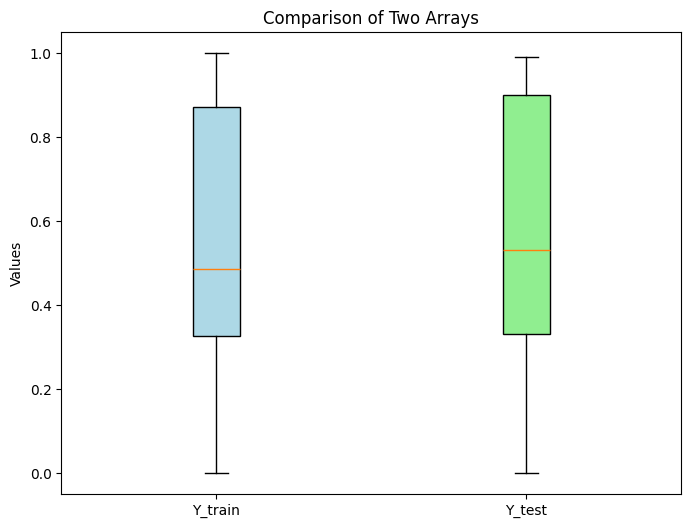

Number of zeros Y_train: 1


In [9]:


import matplotlib.pyplot as plt
import numpy as np  # Only needed if you're creating example data

# Example data (replace with your actual arrays)
array1 = Y_train
array2 =  Y_test

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Create the boxplot
boxplot = plt.boxplot([array1, array2],
                     patch_artist=True,
                     labels=['Y_train', 'Y_test'])

# Customize colors (optional)
colors = ['lightblue', 'lightgreen']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Add title and labels
plt.title('Comparison of Two Arrays')
plt.ylabel('Values')

# Show the plot
plt.show()

num_zeros = Y_train.size - np.count_nonzero(Y_train)

print(f"Number of zeros Y_train: {num_zeros}")

In [10]:
# --- 5. Build LSTM Model ---
h1= 200
h2 =  100
learning_rate = 0.0001
optimizer= Adam(learning_rate= learning_rate ) #'adam'
#Adadelta(learning_rate=learning_rate)
d1 = 0.05
d2 = 0.025

model = Sequential()
# First LSTM layer with return_sequences=True to pass sequences to the next LSTM layer
model.add(LSTM(units= h1, return_sequences=True, input_shape=(look_back, len(features))))
model.add(Dropout( d1 )) # Dropout to prevent overfitting

# Second LSTM layer
model.add(LSTM(units= h2, return_sequences=False)) # return_sequences=False for the last LSTM layer
model.add(Dropout( d2 ))

# Dense output layer for regression (predicting a single value 'y')
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.summary()

for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.__class__.__name__}, Activation: {getattr(layer, 'activation', 'N/A')}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 45, 200)        │       162,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 45, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,901 (1.08 MB)

 Trainable params: 282,901 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Layer 0: LSTM, Activation: <function tanh at 0x7f1d2574c360>
Layer 1: Dropout, Activation: N/A
Layer 2: LSTM, Activation: <function tanh at 0x7f1d2574c360>
Layer 3: Dropout, Activation: N/A
Layer 4: Dense, Activation: <function linear at 0x7f1d2574c9a0>


Epoch 1/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0974 - val_loss: 0.0260
Epoch 2/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0224 - val_loss: 0.0180
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0173 - val_loss: 0.0153
Epoch 4/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0162 - val_loss: 0.0145
Epoch 5/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0145 - val_loss: 0.0137
Epoch 6/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0138 - val_loss: 0.0133
Epoch 7/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0132 - val_loss: 0.0126
Epoch 8/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0125 - val_loss: 0.0122
Epoch 9/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0119 - val_loss: 0.0122
Epoch 10/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0114 - val_loss: 0.0117
Epoch 11/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0110 - val_loss: 0.0111
Epoch 12/100
138/138 ━━━━━━━━━━━━━━━━━━━

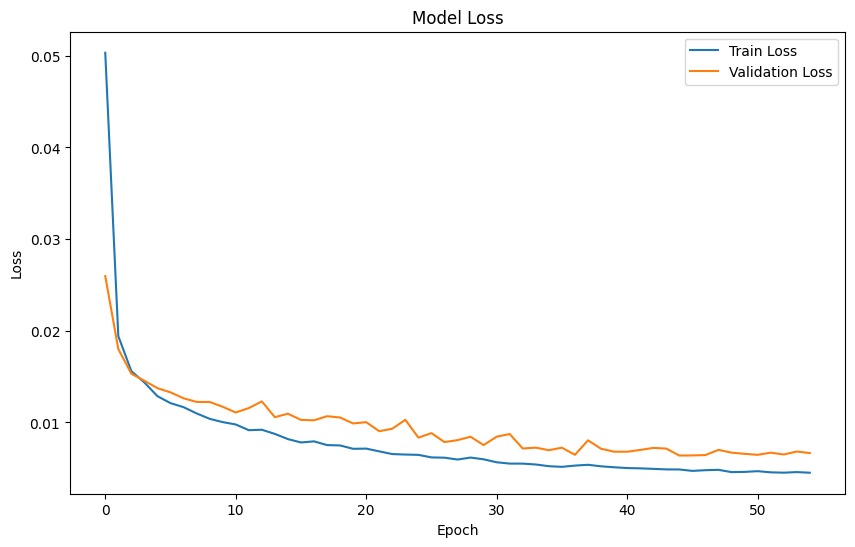

In [11]:
# --- 6. Train the Model ---
# EarlyStopping to stop training when a monitored metric has stopped improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
batch =  16
history = model.fit(X_train, Y_train,
                    epochs=100, # You can increase epochs, EarlyStopping will handle it
                    batch_size= batch ,
                    validation_split=0.2, # Use a portion of training data for validation
                    callbacks=[early_stopping],
                    verbose=1)

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 45, 200)        │       162,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 45, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 848,705 (3.24 MB)

 Trainable params: 282,901 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 565,804 (2.16 MB)

In [13]:
# --- 7. Evaluate the Model ---
train_loss = model.evaluate(X_train, Y_train, verbose=0)
test_loss = model.evaluate(X_test, Y_test, verbose=0)
print(f"\nTrain Loss (MSE): {train_loss:.4f}")
print(f"Test Loss (MSE): {test_loss:.4f}")


Train Loss (MSE): 0.0046
Test Loss (MSE): 0.0061


In [14]:
# --- 8. Make Predictions ---
# Make predictions on the test set
Y_pred_scaled = model.predict(X_test)
print(f"\nShape of Y_pred_scaled: {Y_pred_scaled.shape}")
print(f"Shape of Y_test: {Y_test.shape}")
print(f"Shape of X_test: {X_test.shape}")

# Inverse transform the predictions and actual values to the original scale
Y_pred = scaler_target.inverse_transform(Y_pred_scaled)
Y_test_original = scaler_target.inverse_transform(Y_test.reshape(-1, 1))

r2 = r2_score( Y_test_original ,  Y_pred )

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Y_test_original, Y_pred))
print(f"Test RMSE: {rmse:.4f}")

bias =np.mean( Y_pred- Y_test_original)
print(f"Test bias: { bias:.4f}")

# KGE calculation using hydroeval
# Note: hydroeval's kge function returns KGE, r, alpha, beta by default
kge_value, r_comp, alpha_comp, beta_comp = he.kge( Y_pred , Y_test_original)
#print( kge_value)

std_ratio = np.std( Y_pred ) / np.std( Y_test_original ) # standard deviation ratio
correlation = np.corrcoef( Y_pred.flatten() ,  Y_test_original.flatten() )[0, 1]
print("correlation", correlation)

print(np.std(Y_pred))
print(np.std(Y_test_original))

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Shape of Y_pred_scaled: (688, 1)
Shape of Y_test: (688,)
Shape of X_test: (688, 46, 2)
Test RMSE: 1.6298
Test bias: -0.1173
correlation 0.9671882689910604
6.374144
6.306557805593587


In [15]:



# Example arrays
x = np.array([1, 2, 3, 4, 5])
print(x.shape)
y = np.array([2, 4, 6, 8, 10])

# Compute the correlation coefficient matrix
correlation_matrix = np.corrcoef(x, y)

# Extract the correlation coefficient (Pearson's r)
correlation_example = correlation_matrix[0, 1]

print("Correlation coefficient:", correlation_example)


print("Y_test_original",Y_test_original.shape)
print("Y_test_original",type(Y_test_original) )
print(np.isnan(Y_test_original).sum())
print(np.isinf(Y_test_original).sum())
print("Y_pred",Y_pred.shape)
print("Y_pred",type(Y_pred))
print(np.isnan(Y_pred).sum())
print(np.isinf(Y_pred).sum())

(5,)
Correlation coefficient: 0.9999999999999999
Y_test_original (688, 1)
Y_test_original <class 'numpy.ndarray'>
0
0
Y_pred (688, 1)
Y_pred <class 'numpy.ndarray'>
0
0


In [16]:
#Y_pred
#Y_test_original
#print(Y_pred .shape)
#df_cleaned[train_size:len(Y)]['Date']


#dt_ys = df_cleaned[train_size:len(Y)]#['Date']

print("df_cleaned.tail:",df_cleaned.tail)
print((len(Y)-Y_test.shape[0]  ))
print(len(Y) )
dt_ys = df_cleaned.iloc[  ( df_cleaned.shape[0]-Y_test.shape[0]  )  : df_cleaned.shape[0] ]#['Date']

dt_ys['Y_pred'] = Y_pred
dt_ys['Y_test_original']= Y_test_original

dt_ys[['Date','Y_pred', 	'Y_test_original']]

dt_ys['Date'] = pd.to_datetime( dt_ys['Date'])

print( "dt_ys.tail()", dt_ys.tail() )

print( dt_ys['Date'].dt.month.describe())

summer_df = dt_ys[ dt_ys['Date'].dt.month.isin([6, 7, 8])]

print("summer_df.tail()",summer_df.tail())

summer_df.to_csv( ( model_site[0] + "summer_df.csv") )

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(summer_df['Y_test_original'], summer_df['Y_pred']))
print(f"Test RMSE: {rmse:.4f}")

df_cleaned.tail: <bound method NDFrame.tail of          tmean   site_no       Date  00010_Mean  00060_Mean
882   0.345528  13317660 2006-03-01    0.071770    0.198419
883   0.298566  13317660 2006-03-02    0.057416    0.125692
884   0.288084  13317660 2006-03-03    0.062201    0.161265
885   0.288059  13317660 2006-03-04    0.062201    0.198419
886   0.287036  13317660 2006-03-05    0.052632    0.192885
...        ...       ...        ...         ...         ...
7636  0.580719  13317660 2024-08-27    0.913876    0.028458
7637  0.551157  13317660 2024-08-28    0.885167    0.028458
7638  0.626456  13317660 2024-08-29    0.880383    0.030040
7639  0.736112  13317660 2024-08-30    0.889952    0.030040
7640  0.786916  13317660 2024-08-31    0.904306    0.026087

[3483 rows x 5 columns]>
2750
3438
dt_ys.tail()          tmean   site_no       Date  00010_Mean  00060_Mean     Y_pred  \
7636  0.580719  13317660 2024-08-27    0.913876    0.028458  16.068584   
7637  0.551157  13317660 2024-08-28 

<ipython-input-16-e788007326a5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ys['Y_pred'] = Y_pred
<ipython-input-16-e788007326a5>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ys['Y_test_original']= Y_test_original
<ipython-input-16-e788007326a5>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

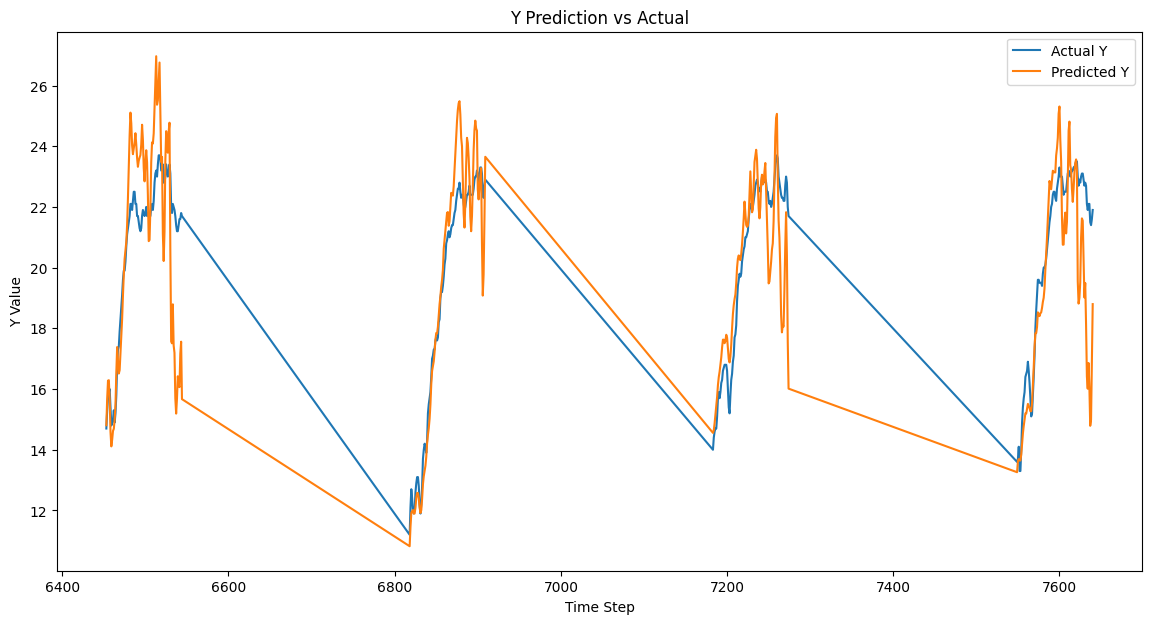

In [17]:
plt.figure(figsize=(14, 7))
plt.plot( summer_df['Y_test_original'], label='Actual Y')
plt.plot( summer_df['Y_pred'], label='Predicted Y')
plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

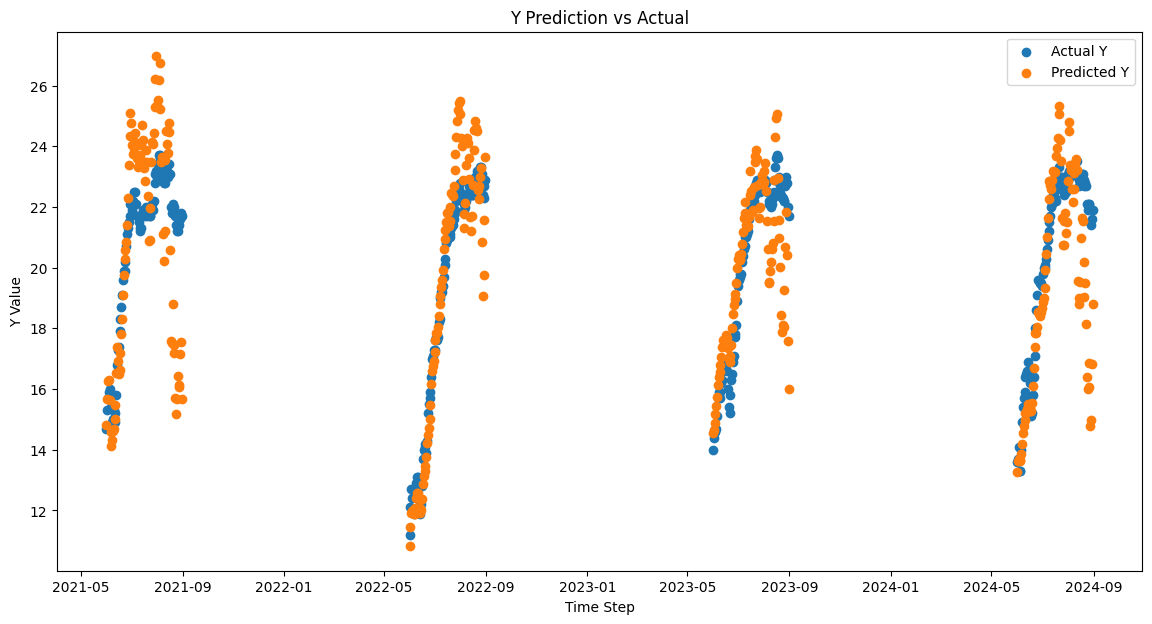

In [18]:
plt.figure(figsize=(14, 7))
plt.scatter(summer_df['Date'], summer_df['Y_test_original'], label='Actual Y')
plt.scatter(summer_df['Date'], summer_df['Y_pred'], label='Predicted Y')



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

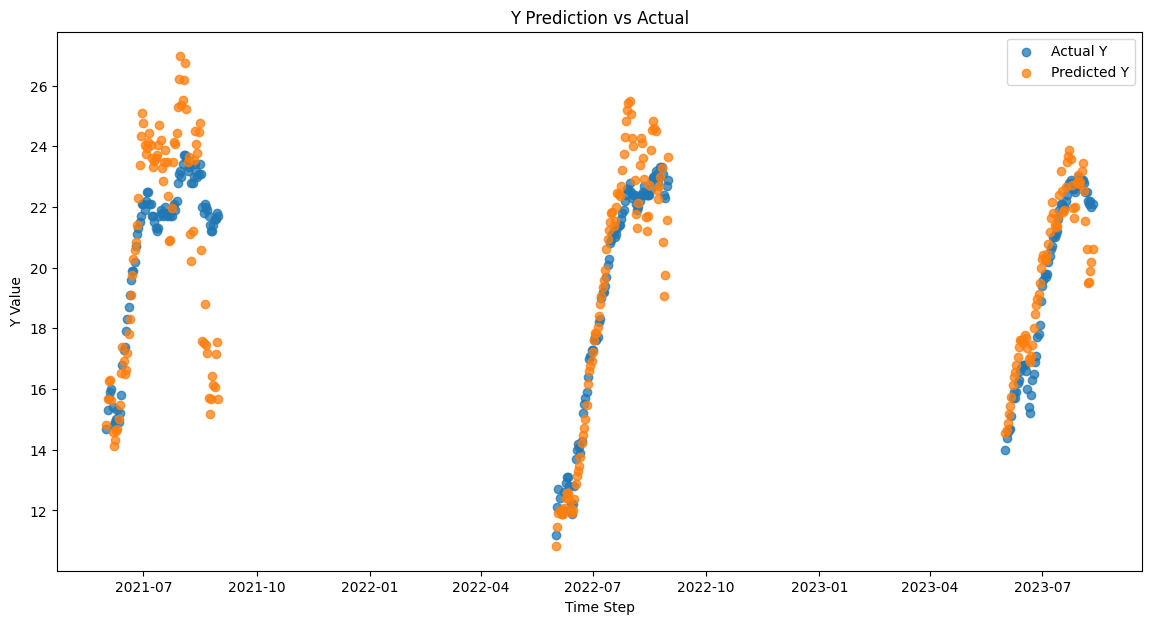

In [19]:
small= summer_df[0:256]
alpha=0.75
plt.figure(figsize=(14, 7))
plt.scatter( small['Date'],  small['Y_test_original'], label='Actual Y',alpha=alpha)
plt.scatter( small['Date'],  small['Y_pred'], label='Predicted Y',alpha=alpha)



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

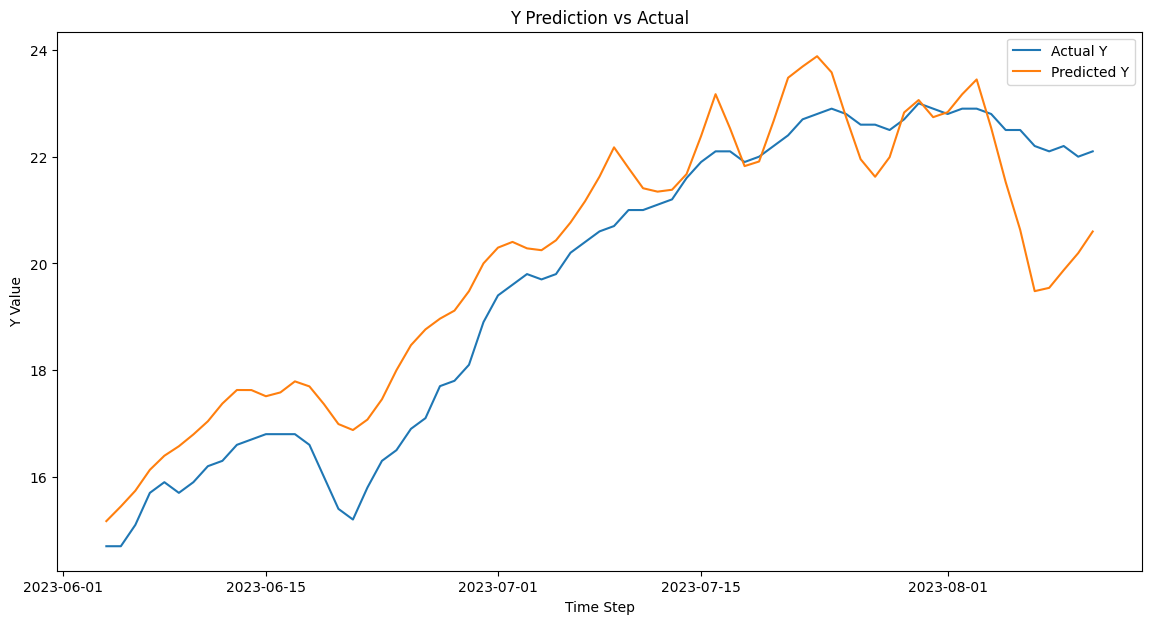

In [20]:
small= summer_df[187:256]

plt.figure(figsize=(14, 7))
plt.plot( small['Date'],  small['Y_test_original'], label='Actual Y')
plt.plot( small['Date'],  small['Y_pred'], label='Predicted Y')



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

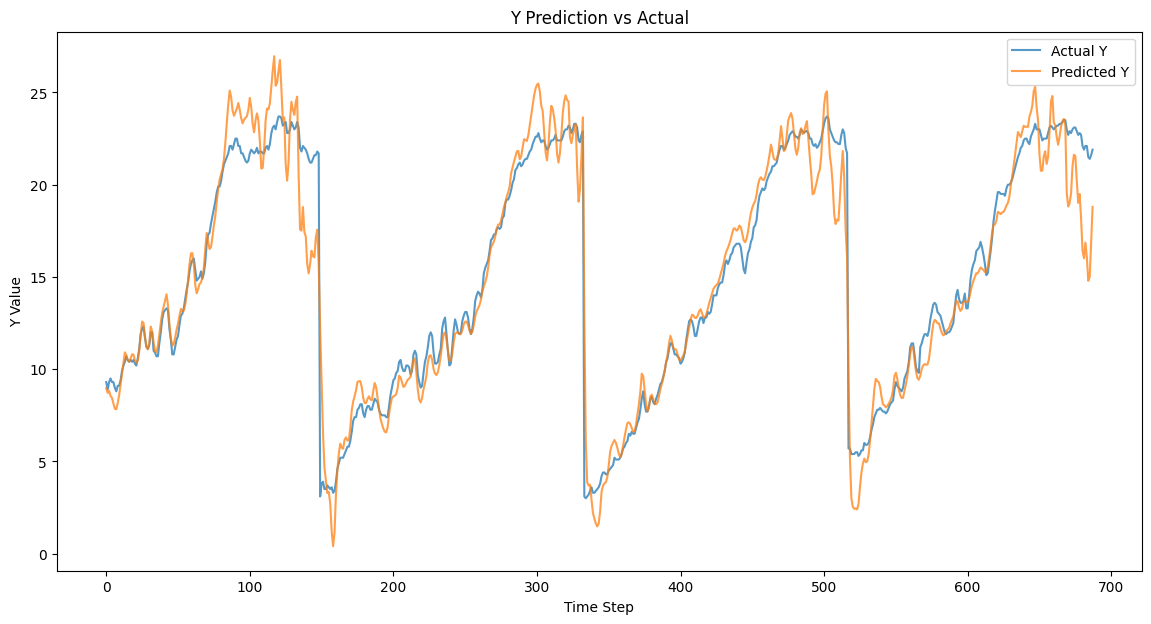

In [21]:



# --- 9. Visualize Predictions vs. Actual ---
plt.figure(figsize=(14, 7))
plt.plot(Y_test_original, label='Actual Y' ,alpha=alpha )
plt.plot(Y_pred, label='Predicted Y' ,alpha=alpha)
plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()


In [22]:
result_df = pd.DataFrame({
    "current_time":[current_time],
                          "model_site": [model_site[0]],
                          "train_month" : [train_month]
                          , "h1":[h1]
                          ,"h2":[h2]
                          ,"d1":[d1]
                          ,"d2":[d2]
                          ,"batch":[batch]
                          ,"look_back":[look_back]


                          ,"optimizer":[optimizer]
    ,'learning_rate':[learning_rate]
    ,"r2" :[r2]
    , "rmse":[rmse]
                           , "bias":[bias]

                       ,   "std_ratio" :[std_ratio]
                        ,  "correlation" :[correlation]


    ,"KGE" : [kge_value]

    })

print(result_df)


result_df.to_csv( model_site[0]+'_result_df.csv' , index=False)

result_df.to_csv('/content/drive/My Drive/LSTM_results/' + model_site[0]+'_result_df_'+   current_time.strftime("%Y%m%d%H%M") + '.csv' , index=False)


                current_time model_site         train_month   h1   h2    d1  \
0 2025-06-09 21:42:03.269504   13317660  [3, 4, 5, 6, 7, 8]  200  100  0.05   

      d2  batch  look_back                                          optimizer  \
0  0.025     16         45  <keras.src.optimizers.adam.Adam object at 0x7f...   

   learning_rate        r2      rmse      bias  std_ratio  correlation  \
0         0.0001  0.933212  1.923478 -0.117304   1.010717     0.967188   

                    KGE  
0  [0.9646025414110336]  


In [23]:
#model.save( (model_site[0]+'_lstm_model.h5') )

         tmean   site_no       Date  00010_Mean  00060_Mean     Y_pred  \
6453  0.733205  13317660 2021-06-01    0.559809    0.195257  14.809677   
6454  0.810952  13317660 2021-06-02    0.588517    0.219763  15.684520   
6455  0.803065  13317660 2021-06-03    0.607656    0.248221  16.278769   
6456  0.720684  13317660 2021-06-04    0.617225    0.260079  16.291704   
6457  0.589626  13317660 2021-06-05    0.622010    0.271937  15.641298   

      Y_test_original      bias  
6453             14.7  0.109677  
6454             15.3  0.384520  
6455             15.7  0.578769  
6456             15.9  0.391704  
6457             16.0 -0.358702  


<ipython-input-24-2b372042d231>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summer_df['bias'] = summer_df['Y_pred'] - summer_df['Y_test_original']


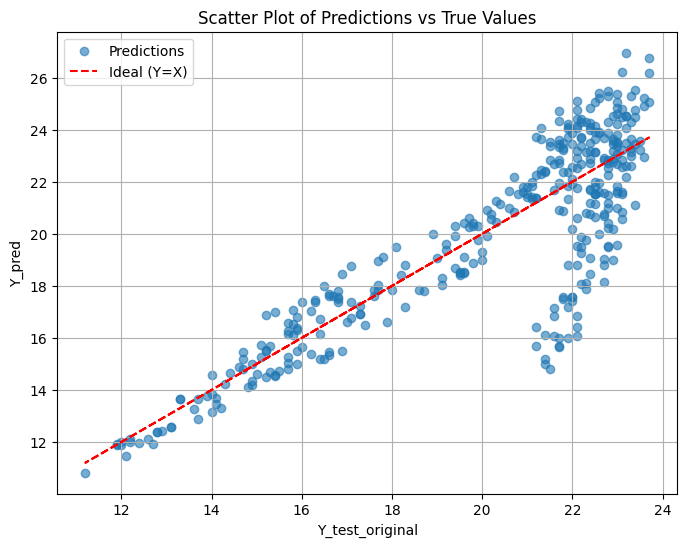

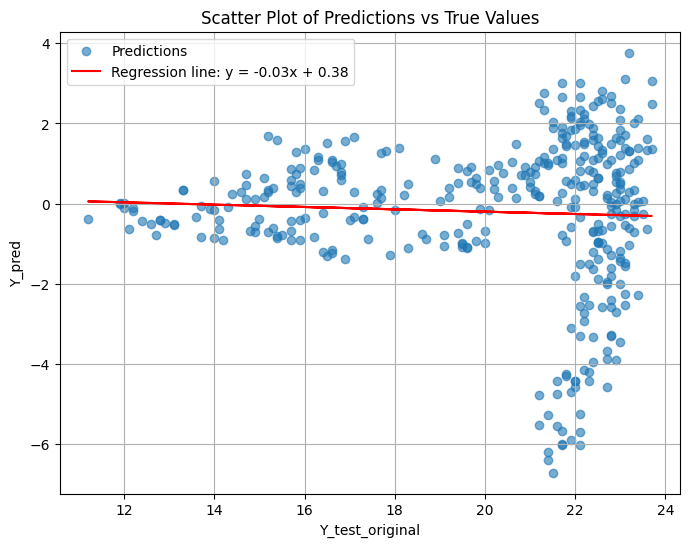

In [24]:
summer_df['bias'] = summer_df['Y_pred'] - summer_df['Y_test_original']
print( summer_df.head() )

# 2. Scatter plot: x = Y_test_original, y = Y_pred
plt.figure(figsize=(8, 6))
plt.scatter( summer_df['Y_test_original'],  summer_df['Y_pred'], alpha=0.6, label='Predictions')
plt.plot( summer_df['Y_test_original'],  summer_df['Y_test_original'], color='red', linestyle='--', label='Ideal (Y=X)')
plt.xlabel('Y_test_original')
plt.ylabel('Y_pred')
plt.title('Scatter Plot of Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

# 2. Scatter plot: x = Y_test_original, y = Y_pred
plt.figure(figsize=(8, 6))
plt.scatter( summer_df['Y_test_original'],  summer_df['bias'], alpha=0.6, label='Predictions')

# Calculate regression line
coefficients = np.polyfit(  summer_df['Y_test_original'],  summer_df['bias'] , 1)  # 1 for linear regression
polynomial = np.poly1d(coefficients)
y_pred = polynomial(  summer_df['Y_test_original']  )
# Plot regression line
plt.plot(  summer_df['Y_test_original'] , y_pred, color='red', label=f'Regression line: y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}')


plt.xlabel('Y_test_original')
plt.ylabel('Y_pred')
plt.title('Scatter Plot of Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

https://www.sciencedirect.com/science/article/pii/S2214581824000648#sec0030